# Two-point Greedy Optimizer

This notebook explores the `PySensors` Two-point Greedy Optimizer `TPGR` for sparse sensor placement for reconstruction. 

For $p$ sensors and $r$ basis modes, while the `QR` optimizer returned exactly $p=r$ sensors in order of decreasing importance through pivoting and placed any subsequent sensors randomly, a `TPGR` optimizer can return a user specified $p$ sensors for any number of basis modes $r$.

See the following reference for more information on Two-Point Greedy Optimizer and Regularized Least Squares Reconstruction ([link](https://arxiv.org/pdf/2307.11838))

`Klishin, Andrei A., J. Nathan Kutz and Krithika Manohar. Data-Induced Interactions of Sparse Sensors. 2023. arXiv:2307.11838 [cond-mat.stat-mech]`

In [1]:
from ftplib import FTP
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.pyplot as plt
import numpy as np
import netCDF4

import pysensors as ps

Import Data

In [2]:
ftp = FTP('ftp.cdc.noaa.gov')
ftp.login()
ftp.cwd('/Datasets/noaa.oisst.v2/')

filenames = ['sst.wkmean.1990-present.nc', 'lsmask.nc']

for filename in filenames:
    localfile = open(filename, 'wb')
    ftp.retrbinary('RETR ' + filename, localfile.write, 1024)
    localfile.close()

ftp.quit();

In [3]:
f = netCDF4.Dataset('sst.wkmean.1990-present.nc')

lat,lon = f.variables['lat'], f.variables['lon']
SST = f.variables['sst']
sst = SST[:]

f = netCDF4.Dataset('lsmask.nc')
mask = f.variables['mask']

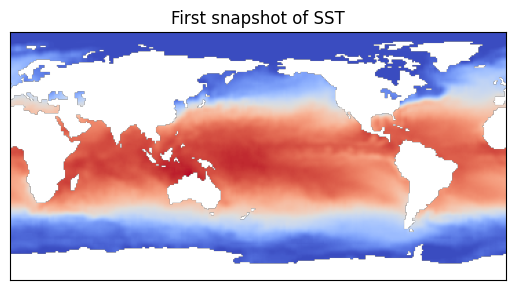

In [4]:
masks = np.bool_(np.squeeze(mask))
snapshot = float("nan")*np.ones((180,360))
snapshot[masks] = sst[0,masks]

plt.imshow(snapshot, cmap=plt.cm.coolwarm)
plt.colorbar
plt.xticks([])
plt.yticks([])
plt.title('First snapshot of SST')
X = sst[:,masks]
X = np.reshape(X.compressed(), X.shape) # convert masked array to array

In [5]:
r=100
flat_prior = np.full(r, 1000)
X_train = X[:1300, :]
X_test = X[1300:, :]

Change the prior to either a flat prior or decreasing prior

In [6]:
prior = flat_prior
# prior='decreasing'

In [7]:
model = ps.SSPOR(
    basis=ps.basis.SVD(n_basis_modes=r),
    optimizer=ps.optimizers.TPGR(n_sensors=25, noise=1, prior=prior)
)
model.fit(X_train)
sensors = model.get_selected_sensors()

Plot the learned sensor locations using the `TPGR` optimizer

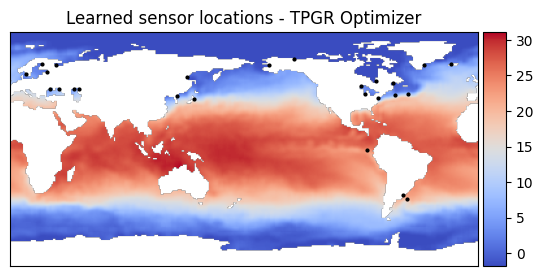

In [8]:
sensor_mask = np.zeros(X.shape[1])
sensor_mask[sensors] = 1
sensor_image = np.zeros_like(snapshot)
sensor_image[masks] = sensor_mask
sensor_positions = np.where(sensor_image == 1)

# Plot sensor locations
fig, ax = plt.subplots()
image = ax.imshow(snapshot, cmap=plt.cm.coolwarm)
ax.scatter(sensor_positions[1], sensor_positions[0], s=4, color='black')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Learned sensor locations - TPGR Optimizer')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(image, cax=cax)

Reconstruct using Regularized Least Squares Reconstruction

In [9]:
x_test = X_test[:, sensors]
predicted_state = model.predict(x_test, noise=1, prior=prior)

Compute and plot the Uncertainty Heatmap

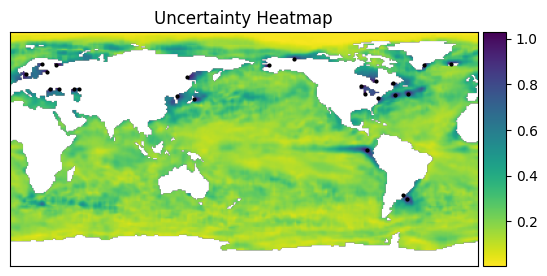

In [10]:
sigma = model.std(prior=prior, noise=1)

uncertainty_map = np.full(X.shape[1], np.nan)
uncertainty_map[:] = sigma
img_uncertainty = np.full_like(snapshot, np.nan, dtype=float)
img_uncertainty[masks] = uncertainty_map

# Plot uncertainty heatmap and sensor locations
fig, ax = plt.subplots()
ax.scatter(sensor_positions[1], sensor_positions[0], s=4, color='black')
image = ax.imshow(img_uncertainty, cmap=plt.cm.viridis_r)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Uncertainty Heatmap')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(image, cax=cax)


Compute and plot One-Point Energy Landscape

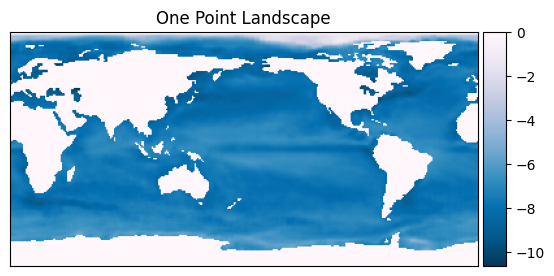

In [11]:
one_point_energy = model.one_pt_energy_landscape(prior=prior, noise=1)
one_pt_landscape = np.zeros(X.shape[1])
one_pt_landscape[:] = one_point_energy
one_pt_landscape_img = np.zeros_like(snapshot)
one_pt_landscape_img[masks] = one_pt_landscape

# Plot one point landscape
fig, ax = plt.subplots()
image = ax.imshow(one_pt_landscape_img, cmap=plt.cm.PuBu_r)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('One Point Landscape')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(image, cax=cax)

Print sensor locations

In [12]:
sensors = [int(x) for x in sensors]
print(sensors)

[9663, 6879, 6906, 8790, 9658, 9422, 11195, 9659, 8211, 7491, 31371, 10591, 6777, 11315, 10790, 21330, 10878, 10569, 9653, 6322, 6930, 6847, 7844, 9095, 32387]


Compute and plot two-point energy landscape.
When the input to `two_pt_sensors` is multiple sensors, the resulting landscape is the sum of two point interactions with all of those sensors. If the input is a single sensor, the resulting landscape will be the two point interaction with that particular sensor. 

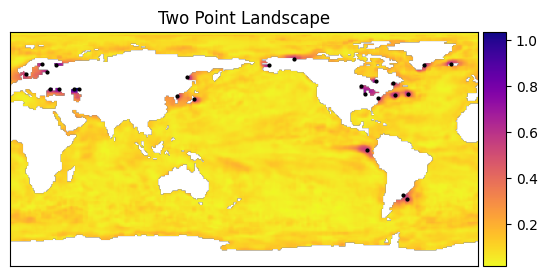

In [13]:
# Use specified or learned sensors
selected_sensors = sensors
# selected_sensors = [9663]

two_point_energy = model.two_pt_energy_landscape(
    selected_sensors=selected_sensors,
    prior=prior,
    noise=1
)
energy_map = np.full(X.shape[1], np.nan)
energy_map[:] = two_point_energy
energy_image = np.full_like(snapshot, np.nan, dtype=float)
energy_image[masks] = energy_map

# Plot two point landscape and sensor locations
fig, ax = plt.subplots()
image = ax.imshow(energy_image, cmap=plt.cm.plasma_r,
                  vmin=np.nanmin(two_point_energy),
                  vmax=np.nanmax(two_point_energy))
ax.scatter(sensor_positions[1], sensor_positions[0], s=4, color='black')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Two Point Landscape')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(image, cax=cax)
